In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
# import acquire
# import prepare
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle

In [2]:
# Acquiring the data using the above module
zillow_sql_query = wrangle.get_zillow_data()
# PLEASE THINK ABOUT ADDING A ZILLOW_COPY TO WORK WITH FROM HERE, THEREBY AVOIDING FUTURE SQL QUERIES
# Code below will have to be updated accordingly.  
zillow = zillow_sql_query.copy()

In [3]:
zillow.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [4]:
# Using my wrangle module to clean and prep the data. NaNs are dropped; so are outliers. 
# In the end, I added an 'age' column and deleted the yearbuilt column (which was more like a categorical variable)
# No outliers were removed from year built, age, or fips
zillow = wrangle.clean_and_prep_data(zillow)

Consider dropping yearbuilt as a column--this is a categorical and is closely related to age, which will be the feature we use instead.

Consider the k value used removing outliers--there are a couple features that may be better with a different value.  I'm thinking of the 1 bedroom houses, for example.

In [5]:
zillow.head()

,bedrooms,bathrooms,sq_ft,tax_value,tax_amount,county,age
6,3.0,4.0,1620.0,847770.0,10244.94,LA,10
7,3.0,2.0,2077.0,646760.0,7924.68,LA,95
18,3.0,1.0,1244.0,169471.0,2532.88,LA,71
19,3.0,2.0,1300.0,233266.0,3110.99,LA,71
20,3.0,2.0,1222.0,290492.0,3870.25,LA,70


In [6]:
#test = wrangle.get_zillow_data()

In [7]:
# test.fips = test.fips.replace({6037.0:'LA',6059.0: 'Orange',6111.0:'Ventura'})
# test

In [8]:
zillow.shape

(1854286, 7)

In [9]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854286 entries, 6 to 2152862
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sq_ft       float64
 3   tax_value   float64
 4   tax_amount  float64
 5   county      object 
 6   age         int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 113.2+ MB


In [10]:
# checking for null values
zillow.isnull().sum()

bedrooms      0
bathrooms     0
sq_ft         0
tax_value     0
tax_amount    0
county        0
age           0
dtype: int64

In [11]:
zillow.columns

Index(['bedrooms', 'bathrooms', 'sq_ft', 'tax_value', 'tax_amount', 'county',
       'age'],
      dtype='object')

In [12]:
# # This is a for loop that is checking every column for any white space. there isn't any
# # also the NaNs, actually. gone now.
# cols = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips']
# for col in cols:
#     print(zillow[col].value_counts(dropna=False,ascending=True))

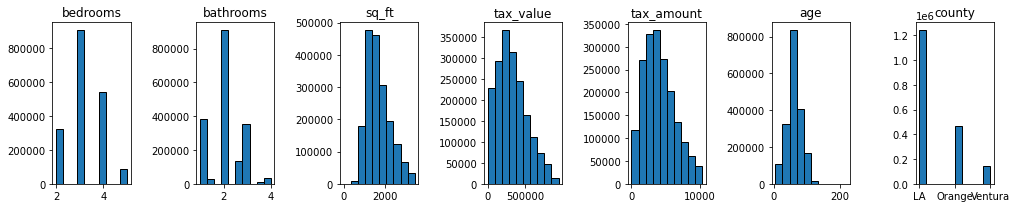

In [13]:
# Here, we create a for loop that makes a histogram for every column. This is the start of my univariate analysis

plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms','sq_ft','tax_value','tax_amount', 'age', 'county']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,8, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    zillow[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()

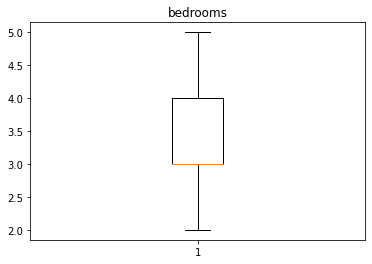

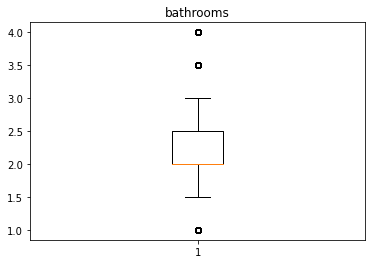

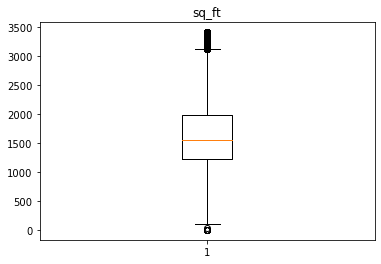

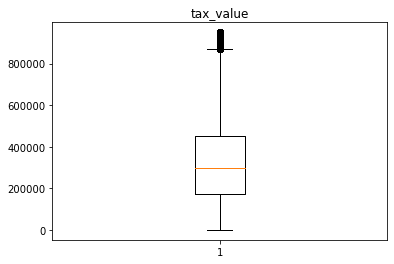

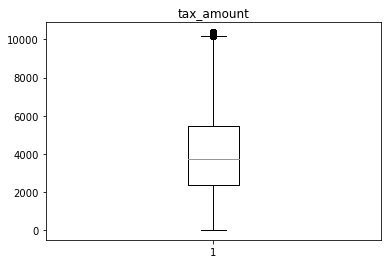

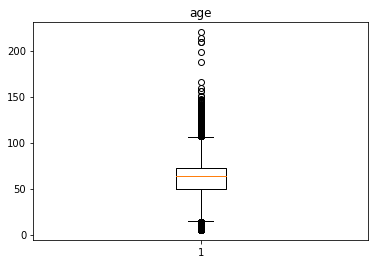

In [14]:
# This cell runs a for loop to visualize a boxplot for every individual variable.

cols = ['bedrooms', 'bathrooms','sq_ft','tax_value','tax_amount', 'age']


for col in cols:
    plt.title(col)
    plt.boxplot(zillow[col])
    plt.show()

In [15]:
# Describe was displaying with scientific notation, so I rounded to 2 places.  
round(zillow.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
bedrooms,1854286.0,3.21,0.78,2.00,3.00,3.00,4.00,5.00
bathrooms,1854286.0,2.05,0.71,1.00,2.00,2.00,2.50,4.00
sq_ft,1854286.0,1653.71,564.43,1.00,1231.00,1548.00,1988.00,3408.00
tax_value,1854286.0,327950.34,198952.85,22.00,173849.25,296630.00,452500.00,950835.00
tax_amount,1854286.0,4069.36,2242.13,16.48,2366.68,3747.14,5487.42,10377.04
age,1854286.0,61.56,20.55,5.00,49.00,64.00,72.00,220.00


### Notice the minimum bedrooms is 2.  I'm sure there were some useful one bedrooms before I removed the outliers.
### The minimum of 1 square foot isn't correct and should be addressed after arriving at MVP
### These are homes around in Los Angeles, Ventura, and Orange County, CA

## Next steps: encode columns and split
### Encode the following:
- ['bedroomcnt','bathroomcnt','fips'] .... on second thought, only encode fips
- I will not use the yearbuilt in the final analysis, and instead use age, which is almost the same thing for my purposes.

In [16]:
encoded = wrangle.encode_zillow(zillow)
encoded.head()

,bedrooms,bathrooms,sq_ft,tax_value,tax_amount,age,LA,Orange,Ventura
6,3.0,4.0,1620.0,847770.0,10244.94,10,1,0,0
7,3.0,2.0,2077.0,646760.0,7924.68,95,1,0,0
18,3.0,1.0,1244.0,169471.0,2532.88,71,1,0,0
19,3.0,2.0,1300.0,233266.0,3110.99,71,1,0,0
20,3.0,2.0,1222.0,290492.0,3870.25,70,1,0,0


# SPLITTING AND SCALING

In [17]:
train, test, validate = wrangle.split_and_scale_zillow(encoded)
train.shape, test.shape, validate.shape

((1038399, 9), (445029, 9), (370858, 9))

# DATA EXPLORATION--BIVARIATE AND MULTIVARIATE

## I decided to rely on an unencoded version of the data set for some of my visual exploration.

In [18]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_value,tax_amount,age,LA,Orange,Ventura
0,0.333333,0.500000,0.578221,0.402894,0.374393,0.158470,0.0,1.0,0.0
1,0.666667,0.333333,0.550925,0.417069,0.476397,0.311475,1.0,0.0,0.0
2,0.000000,0.333333,0.293513,0.220804,0.242438,0.366120,1.0,0.0,0.0
3,0.333333,0.333333,0.432345,0.066427,0.098085,0.333333,0.0,1.0,0.0
4,0.333333,0.333333,0.358086,0.274273,0.323108,0.355191,1.0,0.0,0.0


In [27]:
zillow_corr = zillow.drop(columns=['county']).corr()
zillow_corr

,bedrooms,bathrooms,sq_ft,tax_value,tax_amount,age
bedrooms,1.000000,0.581062,0.594872,0.200091,0.199873,-0.365605
bathrooms,0.581062,1.000000,0.762717,0.354154,0.353663,-0.533615
sq_ft,0.594872,0.762717,1.000000,0.422751,0.416723,-0.464860
tax_value,0.200091,0.354154,0.422751,1.000000,0.969731,-0.249637
tax_amount,0.199873,0.353663,0.416723,0.969731,1.000000,-0.252973
age,-0.365605,-0.533615,-0.464860,-0.249637,-0.252973,1.000000


<AxesSubplot:>

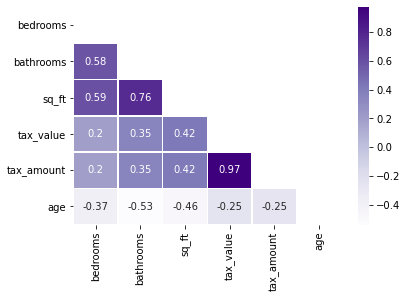

In [29]:
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))

### Make a note of how closely correlated my tax_value and tax_amount are.  I'm of the opinion that this is a little bit of target leakage.  

In [20]:
# takes infinity to run, am i coding it right?
#sns.countplot(x=zillow.tax_value,data=zillow)

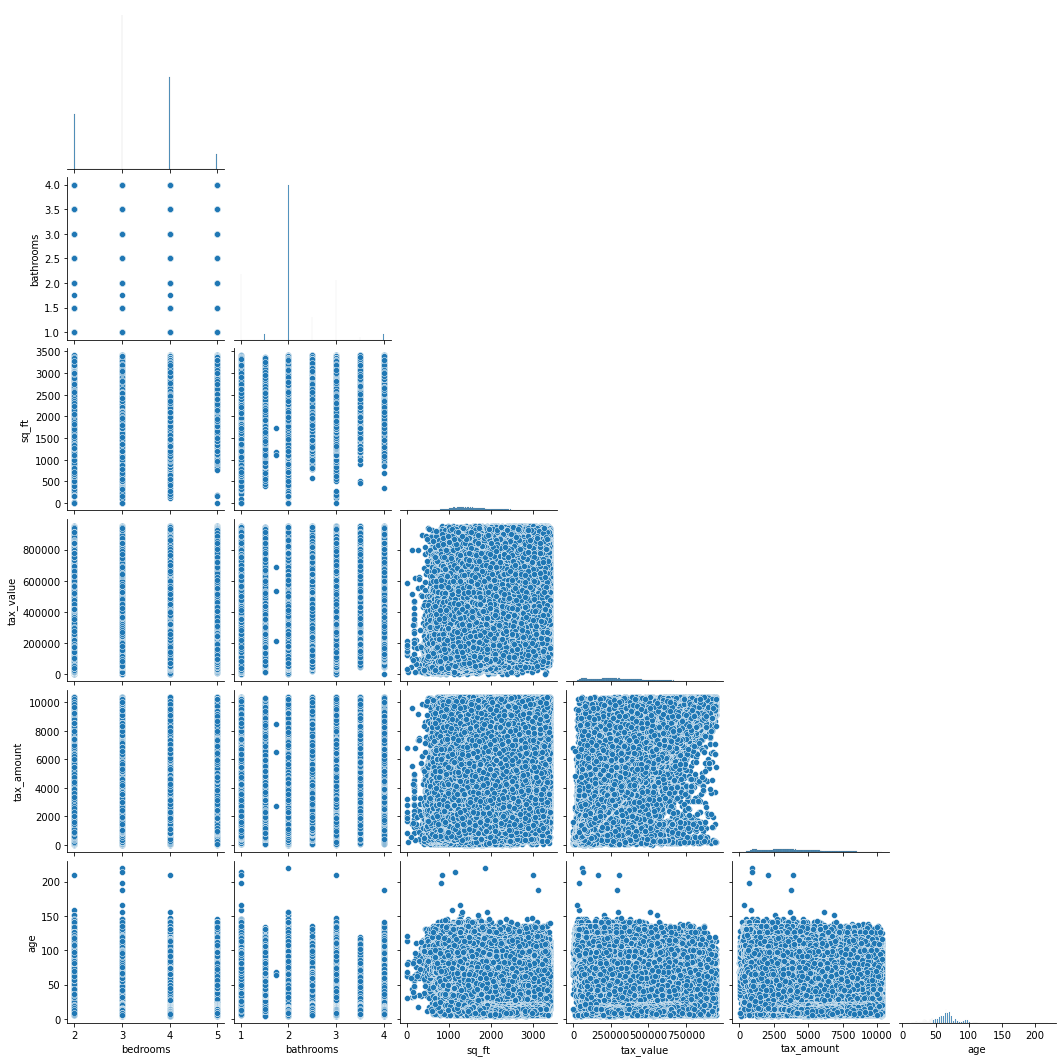

In [40]:
sns.pairplot(data=zillow.drop(columns=['county']),corner=True)

### Here's a takeaway: bedrooms and bathrooms really are a little more categorical or ordinal

In [22]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_value,tax_amount,age,LA,Orange,Ventura
0,0.333333,0.500000,0.578221,0.402894,0.374393,0.158470,0.0,1.0,0.0
1,0.666667,0.333333,0.550925,0.417069,0.476397,0.311475,1.0,0.0,0.0
2,0.000000,0.333333,0.293513,0.220804,0.242438,0.366120,1.0,0.0,0.0
3,0.333333,0.333333,0.432345,0.066427,0.098085,0.333333,0.0,1.0,0.0
4,0.333333,0.333333,0.358086,0.274273,0.323108,0.355191,1.0,0.0,0.0


## Research question number 1: 

Are bigger houses valued higher?

<AxesSubplot:title={'center':'There seems to be a positive correlation between square feet and tax_value'}, xlabel='sq_ft', ylabel='tax_value'>

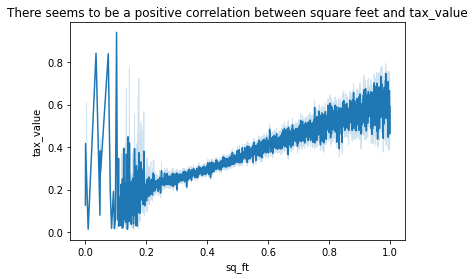

In [41]:
plt.title('There seems to be a positive correlation between square feet and tax_value')

sns.lineplot(x=train.sq_ft, y=train.tax_value)


Hypothesis testing: 

    H_o: Square feet and tax_value are not related
    H_a: Square feet and tax_value are related
    
    The null hypothesis is rejected by the stats test

In [42]:
alpha = 0.05

corr, p = stats.pearsonr(train.sq_ft, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

We reject the null hypothesis


(0.42153230880824294, 0.0)

### There is a moderate correlation between the variables.